# Reading files

In [33]:
import healpy as hp
import healpy.fitsfunc as fitsfunc
import healpy.pixelfunc as pixelfunc
from matplotlib import pyplot as plt
import numpy as np
DirPath    = '/Users/inchanji/Research/sze/data/'
CMBMapFile = 'HFI_SkyMap_143_2048_R2.02_full.fits'
YMapFile   = 'COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
YMapMaskFile   = 'COM_CompMap_Compton-SZMap-masks_2048_R2.00.fits'

GalMapFile = 'HFI_Mask_GalPlane-apo5_2048_R2.00.fits'
PtMapFile  = 'HFI_Mask_PointSrc_2048_R2.00.fits'

LBCGcatalog = 'LBCGs.cat'
NSIDE = 2048;
dtheta = dphi = 0.0012 # 4 arcmin in radian
rad_to_arcmin = 3437.75

In [2]:
# not using it
def pick_random_indice(index = [], num=0, scheme = 1):
    if num == 0: return index
    ind = np.array([0],dtype='i4')
    j = 1l
    Ntot = np.size(index)
    while j < num:
        i = int(np.random.uniform(1, Ntot-1l))
        cnt = ind == i
        if (np.sum(cnt) == 0):
            ind = np.concatenate((ind, np.array([i],dtype='i4')))
            j += 1
    if scheme:
        return index[ind]
    else: 
        return ind

# Reading the SDSS catalog

In [84]:
Ntot = sum(1 for line in open(DirPath+LBCGcatalog)) - 8
print Ntot
DataTable = np.array([line.rstrip('\n') for line in open(DirPath+LBCGcatalog)])[8:]

class Catalog:
    RA = []; DEC = []; Z = []; MAGs = []; B300 = []; B1000 =[]; 
    MASS = []; O2EW = []; O2EWERR =[]; O2VMEAS = []; O2VMERR =[];
    theta = []; phi = []; Rmag = []; # radian
    for i in range(Ntot):
        RA.append(float(DataTable[i].split('\t')[2]))
        DEC.append(float(DataTable[i].split('\t')[3]))
        Z.append(float(DataTable[i].split('\t')[4]))
        MAGs.append( [ float(DataTable[i].split('\t')[5+j]) for j in range(7) ])
        Rmag.append(float(DataTable[i].split('\t')[9]))
        B300.append(float( DataTable[i].split('\t')[12] ) )
        B1000.append(float( DataTable[i].split('\t')[13] ) )  
        MASS.append(float( DataTable[i].split('\t')[14] ) )   
        O2EW.append(float( DataTable[i].split('\t')[15] ) )   
        O2EWERR.append(float( DataTable[i].split('\t')[16] ) )        
        O2VMEAS.append(float( DataTable[i].split('\t')[17] ) )                
        O2VMERR.append(float( DataTable[i].split('\t')[18] ) )  
        theta.append( (90. - DEC[i])  * np.pi / 180.)   ## !!!
        phi.append( (360. - RA[i]) * np.pi / 180.)      ## !!!
        
    RA  = np.array(RA); DEC = np.array(DEC); Z   = np.array(Z); MAGs = np.array(MAGs);
    B300 = np.array(B300); B1000 = np.array(B1000); MASS = np.array(MASS);
    O2EW = np.array(O2EW); O2EWERR = np.array(O2EWERR); O2VMEAS = np.array(O2VMEAS);
    O2VMERR = np.array(O2VMERR); theta = np.array(theta); phi = np.array(phi)
    Rmag = np.array(Rmag)


118188


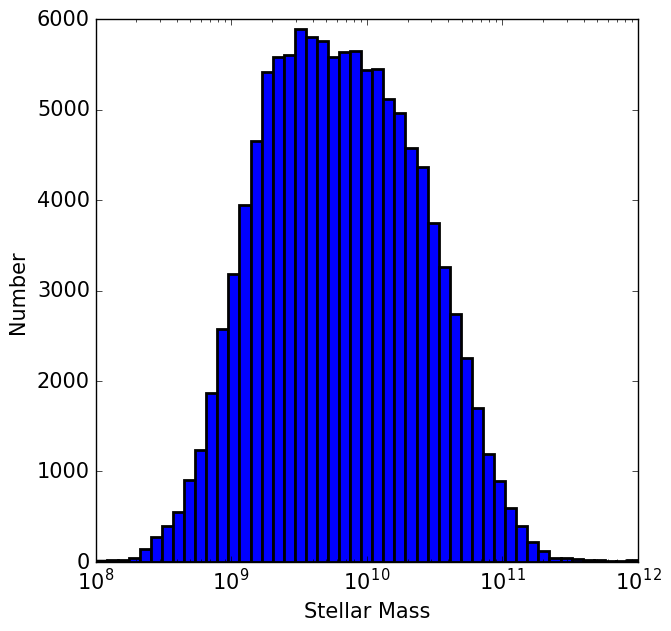

"\nNfig += 1 \n\nval = Catalog.theta\n\nlabel  = ''\n\nminval = 0.; maxval = np.max(val)\n#deln = (maxval - minval) / 20\n\nNfig += 1 \nax = plt.figure(Nfig, figsize=(7,7))\nplt.hist(val, ls='solid', edgecolor='black', log=False,     color='blue',linewidth=2,fill=True,label=label)\nplt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')\nplt.xlabel('', size = 15)\nplt.ylabel('Number ', size = 15)\n#plt.xscale('log')\nplt.show()\n\n"

In [4]:
Nfig = 0
Nfig += 1 

val = Catalog.MASS

label  = ''

minval = 1e8; maxval = 1e12
#deln = (maxval - minval) / 20

Nfig += 1 
ax = plt.figure(Nfig, figsize=(7,7))
plt.hist(val, ls='solid', edgecolor='black', log=False, bins=np.logspace(8, 12, 50), \
    color='blue',linewidth=2,fill=True,label=label)
plt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')
plt.xlabel('Stellar Mass', size = 15)
plt.ylabel('Number ', size = 15)
plt.xscale('log')
plt.show()



'''
Nfig += 1 

val = Catalog.theta

label  = ''

minval = 0.; maxval = np.max(val)
#deln = (maxval - minval) / 20

Nfig += 1 
ax = plt.figure(Nfig, figsize=(7,7))
plt.hist(val, ls='solid', edgecolor='black', log=False, \
    color='blue',linewidth=2,fill=True,label=label)
plt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')
plt.xlabel('', size = 15)
plt.ylabel('Number ', size = 15)
#plt.xscale('log')
plt.show()

'''



# Select galaxy bin

In [88]:
ind_gal  = (Catalog.MASS[:] < 5e12) &  (Catalog.MASS[:] > 1e12)
print np.sum(ind_gal)    
ind_gal = np.where(ind_gal)[0]

43


# Read SZmap & Mask

In [22]:
SZmap0  = hp.read_map(DirPath+YMapFile)
SZForegroundMask  = hp.read_map(DirPath+YMapMaskFile,field = 0,memmap = True) # 40% of sky is ruled out
SZPtMask  = hp.read_map(DirPath+YMapMaskFile,field = 4,memmap = True) # Point sorce
#CMBmap0 = hp.read_map(DirPath+CMBMapFile,field = 0, memmap = True)* 1e6
#GalMap  = hp.read_map(DirPath+GalMapFile, field = 2, memmap = True); # 40% of sky is ruled out
#GalMap  = hp.read_map(DirPath+GalMapFile, field = 3, memmap = True); # 30% of sky is ruled out
#PtMap   = hp.read_map(DirPath+PtMapFile, field = 0, memmap = True);

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


# Make sphreical coordinates as a function of healpix order

In [6]:
dim = len(SZmap0)
index = np.linspace(0,dim-1,dim,dtype='int')
theta_ring, phi_ring = hp.pix2ang(NSIDE, index, nest=False)
#theta_nest, phi_nest = hp.pix2ang(NSIDE, index, nest=True)  # no need to use them. they are ring-ordered.



# Show SZ map

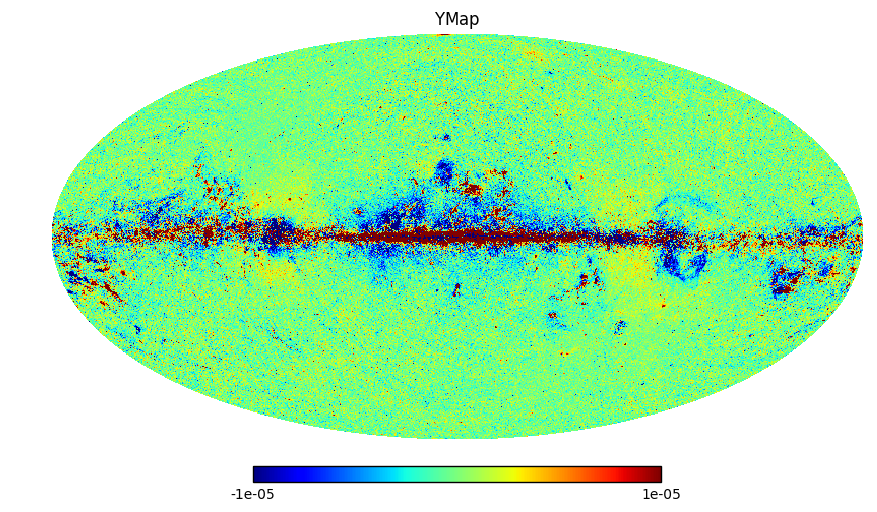

In [25]:
SZmap = SZmap0.copy()

#ind = ( phi_ring < 0.2)  & ( phi_ring > -0.2) & (theta_ring < 0.3)
#SZmap[ind] = 30000.

plt.figure(0)
hp.mollview(SZmap, xsize = 800, title = "$\mathregular{Y Map}$", min = -1e-5, max = 1e-5)
plt.show()

# Masking foreground and point source

In [26]:
ind = (SZForegroundMask[:] == 0.) | (SZPtMask[:] == 0.)
SZmap[ind] = np.nan


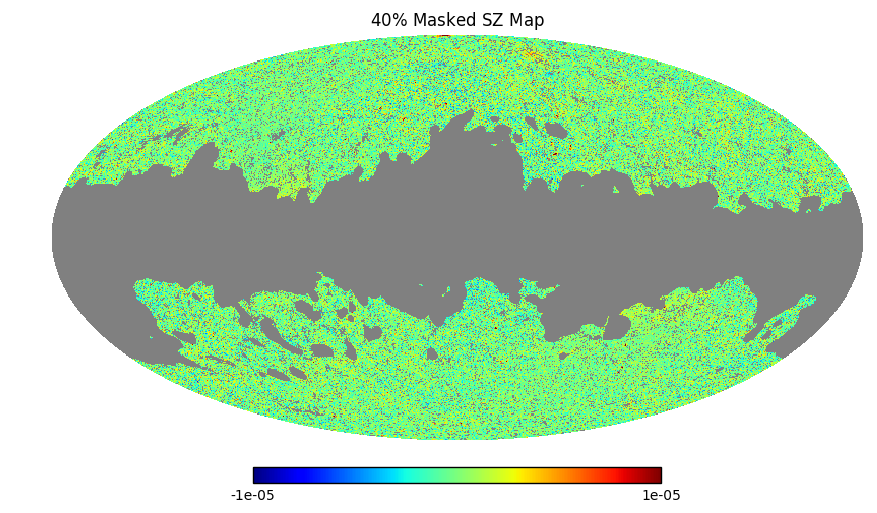

In [28]:
plt.figure(0)
hp.mollview(SZmap, xsize = 800, title = "$\mathregular{40\\%\ Masked\ SZ\ Map}$", min = -1e-5, max = 1e-5)
plt.show()

# Plotting one object

31402
4


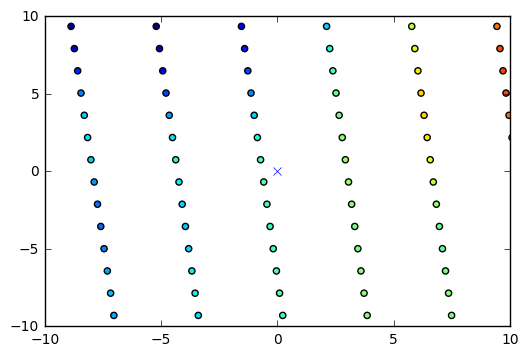

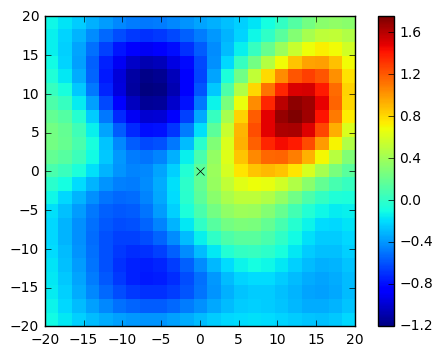

In [103]:

i = ind_gal[5]
print i

Bndry = 20.


theta = Catalog.theta[i]; phi = Catalog.phi[i]
ind_coord = (np.abs(theta - theta_ring) < Bndry/rad_to_arcmin) & (np.abs(phi - phi_ring) < Bndry/rad_to_arcmin)
ind_coord = np.where(ind_coord)[0]

dy = theta - theta_ring[ind_coord]; dx = phi - phi_ring[ind_coord]
dx *= rad_to_arcmin; dy *= rad_to_arcmin;
yval = SZmap[ind_coord]

print np.sum((dx**2. + dy **2. < 9. ) & np.isfinite(yval))


plt.figure(0)
plt.plot([0],[0],'x')
plt.scatter(dx,dy,c = yval)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()


Res = 1.7; sig = 10. / 2.3548

Nsize = int(2.* Bndry/Res)
x1d = np.linspace(-Bndry,Bndry, Nsize); y1d = np.linspace(-Bndry,Bndry, Nsize);
X, Y = np.meshgrid(x1d, y1d)

R = np.sqrt(X**2. + Y**2.)
MapStack = np.zeros((Nsize, Nsize))
norm = np.sum(np.exp(-0.5 * ((X)**2. + (Y)**2.) / sig**2.  ) )

for i in range(len(yval)):
    if np.isfinite(yval[i]):
        MapStack += np.exp(-0.5 * ((X-dx[i])**2. + (Y-dy[i])**2.) / sig**2.  ) / norm * yval[i]

extent = (-Bndry,Bndry, -Bndry, Bndry)
plt.figure(0) 
plt.imshow(MapStack*1e6, origin='lower',zorder=0,extent = extent, interpolation='nearest')#, vmin = -3e-8, vmax = 1e-7)
plt.plot([0],[0],'kx')
plt.xlim(-Bndry,Bndry)
plt.ylim(-Bndry,Bndry)
plt.colorbar()
plt.show()


# Collect all images 

In [109]:

stack_img = []
Res = 1.7; sig = 5. / 2.3548
Bndry = 20.
Nsize = int(2.* Bndry/Res)
x1d = np.linspace(-Bndry,Bndry, Nsize); y1d = np.linspace(-Bndry,Bndry, Nsize);
X, Y = np.meshgrid(x1d, y1d)

R = np.sqrt(X**2. + Y**2.)
MapStack = np.zeros((Nsize, Nsize))
norm = np.sum(np.exp(-0.5 * ((X)**2. + (Y)**2.) / sig**2.  ) )

for i in (ind_gal):
    theta = Catalog.theta[i]; phi = Catalog.phi[i]
    ind_coord = (np.abs(theta - theta_ring) < Bndry/rad_to_arcmin) & (np.abs(phi - phi_ring) < Bndry/rad_to_arcmin)
    ind_coord = np.where(ind_coord)[0]    
    
    dy = theta - theta_ring[ind_coord]; dx = phi - phi_ring[ind_coord]
    dx *= rad_to_arcmin; dy *= rad_to_arcmin;
    yval = SZmap[ind_coord]    

    cnt = np.sum((dx**2. + dy **2. < 9. ) & np.isfinite(yval))
    # if the objects are in the masked regions, cnt = 0 whithin dx**2. + dy **2. < 9.
    if cnt > 0:
        MapStack[:] = 0.
        for j in range(len(yval)):
            if np.isfinite(yval[j]):
                MapStack += np.exp(-0.5 * ((X-dx[j])**2. + (Y-dy[j])**2.) / sig**2.  ) / norm * yval[j]
        stack_img.append(MapStack)
                    

In [112]:
final_image = np.sum(stack_img, axis=0)
#final_image = np.median(stack_img, axis=0)

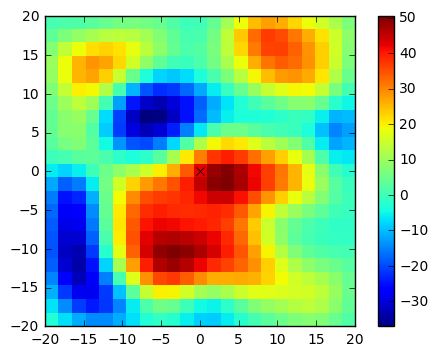

In [113]:
extent = (-Bndry,Bndry, -Bndry, Bndry)
plt.figure(0) 
plt.imshow(final_image*1e6, origin='lower',zorder=0,extent = extent, interpolation='nearest')#, vmin = -3e-8, vmax = 1e-7)
plt.plot([0],[0],'kx')
plt.xlim(-Bndry,Bndry)
plt.ylim(-Bndry,Bndry)
plt.colorbar()
plt.show()

In [51]:
stack_img

[]